In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor, Pool, cv

## Первичная предобработка данных и визуализация

Импорт исходного датасета в формате gpd.
Основное отличие GeoDataFrame - наличие специального столбца 'geometry', который содержит геометрические объекты, такие как точки, линии и полигоны. Это позволяет представлять сложные географические структуры в табличном формате, сохраняя при этом их пространственные характеристики.

In [2]:
# Импорт загруженных станций
shapefile = gpd.read_file("/kaggle/input/rzhd-hack/selected1.shp")
# Импорт участков дорог между ними
shapefile2 = gpd.read_file("/kaggle/input/rzhd-hack/all_routes_v2.shp")

# Удаляем лишние колонки (добавим дополнительно оставшиеся лишние колонки)
geometry = shapefile2.geometry
non_geometry = shapefile2.drop(columns='geometry')

Так как строки полученного датасета состоят из кусочков путей, попробуем аггрегировать данные по путям с помощью суммирования.

In [3]:
aggregated_non_geometry = non_geometry.groupby(['origin', 'destinatio']).sum().reset_index()
# Объединение геометрических столбцов путем группировки и применения unary_union
aggregated_geometry = shapefile2.groupby(['origin', 'destinatio'])['geometry'].apply(lambda x: x.unary_union).reset_index()

# Объединение агрегированных негеометрических данных с агрегированной геометрией
aggregated_data = aggregated_non_geometry.merge(aggregated_geometry, on=['origin', 'destinatio'])

# Преобразуем в формат GeoDataFrame
aggregated_data = gpd.GeoDataFrame(aggregated_data, geometry='geometry')

print(aggregated_data)

                    origin                     destinatio        id  oneway  \
0       Александро-Невская                         Рыбное  10256132       0   
1   Бекасово-Сортировочное                        Вековка  41833615      60   
2   Бекасово-Сортировочное          Люблино-Сортировочное  24567225      37   
3   Бекасово-Сортировочное                  Малоярославец  14502759      33   
4   Бекасово-Сортировочное  Москва-Сортировочная-Киевская  12674521      21   
..                     ...                            ...       ...     ...   
75                   Унеча                       Стародуб   7738604       0   
76                 Фрязево                        Ногинск   3851760      15   
77                 Щёлково               Лосиноостровская  11262971       0   
78       Ярославль-Главный               Лосиноостровская  26472587      84   
79       Ярославль-Главный                  Орехово-Зуево  20633738      66   

                                             revers

Отдельные графики точек и путей

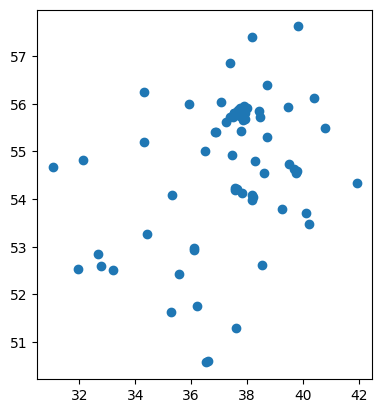

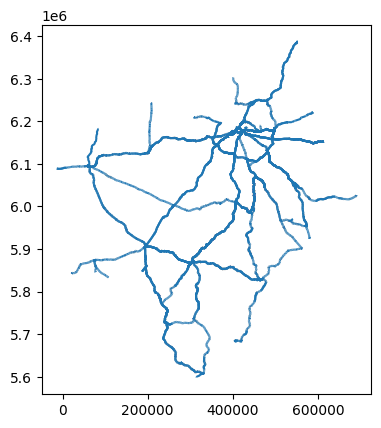

In [4]:
# График станций
shape2 = aggregated_data
shapefile.plot()
plt.show()

# График путей
shape2.plot()
plt.show()

In [5]:
# Assuming your GeoDataFrame 'shapefile2' has a proper CRS set
# Calculate the length of each geometry in meters
aggregated_data['length_km'] = aggregated_data['geometry'].length / 1000

# Print the result
print(aggregated_data[['origin','destinatio','geometry', 'length_km']])

                    origin                     destinatio  \
0       Александро-Невская                         Рыбное   
1   Бекасово-Сортировочное                        Вековка   
2   Бекасово-Сортировочное          Люблино-Сортировочное   
3   Бекасово-Сортировочное                  Малоярославец   
4   Бекасово-Сортировочное  Москва-Сортировочная-Киевская   
..                     ...                            ...   
75                   Унеча                       Стародуб   
76                 Фрязево                        Ногинск   
77                 Щёлково               Лосиноостровская   
78       Ярославль-Главный               Лосиноостровская   
79       Ярославль-Главный                  Орехово-Зуево   

                                             geometry   length_km  
0   MULTILINESTRING ((580388.745 5926227.814, 5804...  207.117385  
1   MULTILINESTRING ((589802.650 6148604.962, 5897...  409.087282  
2   MULTILINESTRING ((420474.245 6171937.324, 4204...  122.1712

Импорт тренировочного датасета, который состоит из времени поезда в пути и пунктов прибытия и отбытия.

In [6]:
train_df = pd.read_csv("/kaggle/input/rzhd-hack/dataset_external.csv")
train_df

,index,value,route_start,route_end
0,1198,4.150000,Кусково,Яничкино
1,2983,14.300000,Вековка,Курск
2,3418,7.116667,Люблино-Сортировочное,Рязань-2
3,1955,20.333333,Красное,Погар
4,1697,13.900000,Белгород,Елец
...,...,...,...,...
1514,2424,10.683333,Люберцы II,Волоколамск
1515,1364,9.166667,Волоколамск,Вековка
1516,1419,10.866667,Перово,Елец
1517,1723,9.483333,Волоколамск,Узуново


Создание графа, на котором будет обучаться сетка.

In [7]:
all_routes = aggregated_data

G = nx.Graph()

# Добавляем узлы в виде станций
stations = set(all_routes['origin']).union(set(all_routes['destinatio']))
G.add_nodes_from(stations)

# Добавляем ребра в виде расстояний между пунктами
for index, row in all_routes.iterrows():
    G.add_edge(row['origin'], row['destinatio'], weight=row['length_km'])
    # У нас есть переменная reverced, которая должна сделать граф ориентированным
    G.add_edge(row['destinatio'], row['origin'], weight=row['length_km'])

In [8]:
# Функция поиска кратчайшего пути между начальной и конечной станциями
def find_shortest_path(start_station, end_station):
    try:
        if not(start_station in G and end_station in G):
            return 0,0,0
        else:
            shortest_path = nx.shortest_path(G, start_station, end_station, weight='weight')
            shortest_distance = nx.shortest_path_length(G, start_station, end_station, weight='weight')
            num_stations = len(shortest_path) - 1
            return shortest_path, shortest_distance, num_stations
    except nx.NetworkXNoPath:
        return None, float('inf'), float('inf')  # No path found


for index, row in train_df.iterrows():
    start_station = row['route_start']
    end_station = row['route_end']
    
    shortest_path, shortest_distance, num_stations = find_shortest_path(start_station, end_station)
    
    if shortest_path:
        train_df.at[index, 'optimal_distance_km'] = shortest_distance
        train_df.at[index, 'num_stations'] = num_stations
    else:
        train_df.at[index, 'optimal_distance_km'] = None
        train_df.at[index, 'num_stations'] = None

print(train_df)

      index      value            route_start    route_end  \
0      1198   4.150000                Кусково     Яничкино   
1      2983  14.300000                Вековка        Курск   
2      3418   7.116667  Люблино-Сортировочное     Рязань-2   
3      1955  20.333333                Красное        Погар   
4      1697  13.900000               Белгород         Елец   
...     ...        ...                    ...          ...   
1514   2424  10.683333             Люберцы II  Волоколамск   
1515   1364   9.166667            Волоколамск      Вековка   
1516   1419  10.866667                 Перово         Елец   
1517   1723   9.483333            Волоколамск      Узуново   
1518   1006   6.466667               Рязань-2       Перово   

      optimal_distance_km  num_stations  
0              268.887101           2.0  
1             1166.548994           5.0  
2              314.678247           2.0  
3             2668.333561           7.0  
4              822.466978           4.0  
...

Загружаем тестовый датасет:

In [9]:
test_df = pd.read_csv("/kaggle/input/rzhd-hack/dataset_internal.csv")

In [10]:
# Поиск кратчайших путей на графе
for index, row in test_df.iterrows():
    start_station = row['route_start']
    end_station = row['route_end']
    
    shortest_path, shortest_distance, num_stations = find_shortest_path(start_station, end_station)
    
    if shortest_path:
        test_df.at[index, 'optimal_distance_km'] = shortest_distance
        test_df.at[index, 'num_stations'] = num_stations
    else:
        test_df.at[index, 'optimal_distance_km'] = None
        test_df.at[index, 'num_stations'] = None

print(test_df)

      index                 route_start               route_end  \
0      2623                      Вязьма                 Щёлково   
1      4413                    Аэропорт                   Лесок   
2       480                     Узуново           Малоярославец   
3      4409                    Серпухов                   Лесок   
4      9286                  Кунцево II                 Петушки   
...     ...                         ...                     ...   
1514   1676                        Елец                  Перово   
1515   8047                 Зелёный Бор                 Вековка   
1516     37  Москва-Товарная-Смоленская            Курбакинская   
1517   1179      Смоленск-Сортировочный                Владимир   
1518   8020                    Аэропорт  Бекасово-Сортировочное   

      optimal_distance_km  num_stations  
0              757.835709           4.0  
1                     NaN           NaN  
2              438.417927           4.0  
3              433.693874  

## Построение предсказательной модели

In [11]:
X = train_df.drop(columns=['value', 'route_start', 'route_end'])
y = train_df['value']

# Разбиваем выборку на тренировочную и тестовую
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
catboost_params = {
    'iterations': 1000,
    'learning_rate': 0.1,
    'depth': 10,
    'loss_function': 'RMSE',
    'random_seed': 42
}

train_pool = Pool(data=X_train, label=y_train)
val_pool = Pool(data=X_val, label=y_val)

# Запускаем кросс-валидацию
cv_results = cv(pool=train_pool,
                params=catboost_params,
                fold_count=5,  
                verbose=100,  
                plot=True)  

best_iteration = len(cv_results)

print(f"Best RMSE: {cv_results['test-RMSE-mean'].min():.2f} ± {cv_results['test-RMSE-std'].mean():.2f} at iteration {best_iteration}")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]
0:	learn: 11.0241685	test: 11.0889011	best: 11.0889011 (0)	total: 61.9ms	remaining: 1m 1s
100:	learn: 2.3384428	test: 2.8749325	best: 2.8440282 (64)	total: 542ms	remaining: 4.83s
200:	learn: 1.8911273	test: 2.9576876	best: 2.8440282 (64)	total: 1.11s	remaining: 4.41s
300:	learn: 1.6081349	test: 3.0034579	best: 2.8440282 (64)	total: 1.63s	remaining: 3.78s
400:	learn: 1.3954506	test: 3.0692315	best: 2.8440282 (64)	total: 2.18s	remaining: 3.25s
500:	learn: 1.2344564	test: 3.1067524	best: 2.8440282 (64)	total: 2.7s	remaining: 2.69s
600:	learn: 1.1118901	test: 3.1266484	best: 2.8440282 (64)	total: 3.22s	remaining: 2.14s
700:	learn: 1.0148374	test: 3.1400066	best: 2.8440282 (64)	total: 3.76s	remaining: 1.6s
800:	learn: 0.9283742	test: 3.1559942	best: 2.8440282 (64)	total: 4.32s	remaining: 1.07s
900:	learn: 0.8537218	test: 3.1712645	best: 2.8440282 (64)	total: 4.86s	remaining: 534ms
999:	learn: 0.7984685	test: 3.1915437	best: 2.8440282 (64)	total: 5.43s	remaining: 0us



In [13]:
# CatBoostRegressor с лучшими параметрами
best_model = CatBoostRegressor(iterations=best_iteration,
                               learning_rate=0.1,
                               depth=10,
                               loss_function='RMSE',
                               random_seed=42)

best_model.fit(X, y, verbose=100)

0:	learn: 4.3629125	total: 5.67ms	remaining: 5.66s
100:	learn: 2.3784499	total: 429ms	remaining: 3.82s
200:	learn: 2.0189467	total: 890ms	remaining: 3.54s
300:	learn: 1.7986002	total: 1.34s	remaining: 3.11s
400:	learn: 1.6383120	total: 1.8s	remaining: 2.68s
500:	learn: 1.5063901	total: 2.26s	remaining: 2.25s
600:	learn: 1.4011159	total: 2.73s	remaining: 1.81s
700:	learn: 1.3118410	total: 3.21s	remaining: 1.37s
800:	learn: 1.2388368	total: 3.71s	remaining: 921ms
900:	learn: 1.1789800	total: 4.19s	remaining: 460ms
999:	learn: 1.1274715	total: 4.66s	remaining: 0us


Метрики:

In [14]:
y_pred = best_model.predict(X_val)

from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate RMSE and MAE
rmse = mean_squared_error(y_val, y_pred, squared=False)
mae = mean_absolute_error(y_val, y_pred)

print(f"RMSE: {rmse:.2f} kilometers")
print(f"MAE: {mae:.2f} kilometers")


RMSE: 1.42 kilometers
MAE: 0.76 kilometers


Предсказания:

In [15]:
test_pred = best_model.predict(test_df.drop(columns=['route_start', 'route_end']))
print(test_pred)

[10.89952271 10.54421412  9.49124487 ... 10.54314671 12.25671874
  6.23584733]


In [16]:
test_df["value"] = test_pred

In [17]:
test_df

,index,route_start,route_end,optimal_distance_km,num_stations,value
0,2623,Вязьма,Щёлково,757.835709,4.0,10.899523
1,4413,Аэропорт,Лесок,NaN,NaN,10.544214
2,480,Узуново,Малоярославец,438.417927,4.0,9.491245
3,4409,Серпухов,Лесок,433.693874,3.0,7.351324
4,9286,Кунцево II,Петушки,716.954299,5.0,11.967232
...,...,...,...,...,...,...
1514,1676,Елец,Перово,NaN,NaN,9.307269
1515,8047,Зелёный Бор,Вековка,454.405937,3.0,6.831107
1516,37,Москва-Товарная-Смоленская,Курбакинская,703.990153,4.0,10.543147
1517,1179,Смоленск-Сортировочный,Владимир,941.980834,4.0,12.256719
